In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1)

### Generate data

In [3]:
def generate_normal_series(number, mean):
    data = []
    labels = []
    for i in range(number):
        x = []
        label = []
        x_prev = 0
        coef = 0.75
        length = scipy.stats.randint.rvs(50, 200)
        for l in range(length):
            x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean, scale=1)
            x.append(x_curr)
            x_prev = x_curr
            label.append(0)
        data.append(np.asarray(x))
        labels.append(np.asarray(label))
    return data, labels

In [4]:
number_normal = 500
data_normal, labels_normal = generate_normal_series(number_normal, 0)

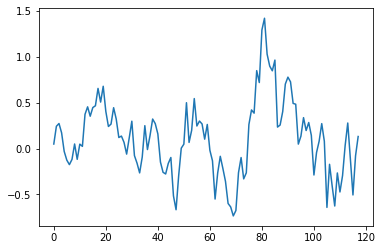

In [5]:
plt.plot(data_normal[0])

In [6]:
def generate_anomaly_series(number, mean_old, mean_new):
    data = []
    labels = []
    for i in range(number):
        x = []
        label = []
        x_prev = 0
        coef = 0.75
        length = scipy.stats.randint.rvs(50, 200)
        chane_point = scipy.stats.randint.rvs(10, length-20)
        for l in range(length):
            if l < chane_point:
                x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean_old, scale=1)
                label.append(0)
                
            else:
                x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean_new, scale=1)
                label.append(1)
            x.append(x_curr)
            x_prev = x_curr
        data.append(np.asarray(x))
        labels.append(np.asarray(label))
    return data, labels

In [7]:
number_anomaly = 200
data_anomaly, labels_anomaly = generate_anomaly_series(number_anomaly, 0, 5)

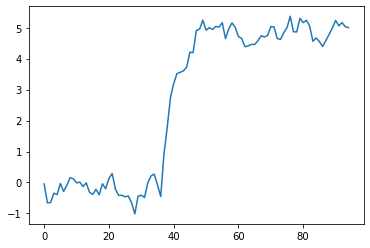

In [8]:
plt.plot(data_anomaly[0])

In [14]:
all_ts_data = np.asarray(data_normal + data_anomaly)
all_labels = np.asarray(labels_normal + labels_anomaly)

In [15]:
ts_train, ts_val, label_train, label_val = train_test_split(all_ts_data, all_labels, 
                                                            test_size=0.25, shuffle=True,
                                                            random_state=42)

In [16]:
test_number_normal = 500
test_data_normal, test_labels_normal = generate_normal_series(test_number_normal, 0)

test_number_anomaly = 200
test_data_anomaly, test_labels_anomaly = generate_anomaly_series(test_number_anomaly, 0, 5)

test_data = np.asarray(test_data_normal + test_data_anomaly)
test_labels = np.asarray(test_labels_normal + test_labels_anomaly)

### Experiment №1. 
Each signal is corresponded to one label at the end.
Use LSTM and BCELoss()

In [17]:
def create_sequences(ts, label, tw):
    inout_seq = []
    for t in range(len(ts)):
        curr_ts = torch.FloatTensor(ts[t]).view(-1)
        curr_label = torch.IntTensor(label[t]).view(-1)
        for i in range(len(curr_ts) - tw):
            train_seq = curr_ts[i:i+tw]
            train_label = curr_label[i:i+tw]
            inout_seq.append((train_seq ,train_label))
    return inout_seq

In [34]:
# input data parameters
input_size = 64
output_size = 64

# model hyperparameters
batch_size = 128
learning_rate = 1e-3

In [19]:
# prepare data in right format for LSTM

train_inout_seq = create_sequences(ts_train, label_train, input_size)
test_inout_seq = create_sequences(test_data, test_labels, input_size)
val_inout_seq = create_sequences(ts_val, label_val, input_size)

train_inout_seq = train_inout_seq[:-(len(train_inout_seq)%batch_size)]
test_inout_seq = test_inout_seq[:-(len(test_inout_seq)%batch_size)]
val_inout_seq = val_inout_seq[:-(len(val_inout_seq)%batch_size)]

train_loader = DataLoader(train_inout_seq, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_inout_seq, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_inout_seq, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [88]:
class NN(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(NN, self).__init__()
        self.input_size = input_size
        self.layer = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, output_size),
            nn.Softmax()
        )
        
    def forward(self, input):
        out = self.layer(input)
        return out    

In [89]:
device = torch.device("cpu")

In [90]:
model = NN(input_size=input_size, output_size=output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.BCELoss()

In [63]:
epochs = 20
print_every = 500
valid_loss_min = np.Inf

loss_list = []
acc_list = []
counter = 0
model.train()

for i in range(epochs):    
    for inputs, labels in tqdm(train_loader):
        counter += 1
        inputs, labels = inputs.to(device), labels.to(device)        
        model.zero_grad()
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_function(output.squeeze(), labels.float())
        
        loss_list += [loss.clone().detach()]
        accuracy = (output > 0.5).long() == labels
        acc_list += [accuracy.detach().float().mean()]
        
        loss.backward()
        optimizer.step()
        
        if counter%print_every == 0:
            val_losses = []
            val_outputs = []
            model.eval()
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_out = model(val_inputs)
                val_loss = loss_function(val_out.squeeze(), val_labels.float())
                val_losses.append(val_loss.item())
                val_outputs += [val_out.clone().detach()]
                
            val_outputs_one = torch.cat(val_outputs, 0)
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
        

C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 3/20... Step: 500... Loss: 0.809470... Val Loss: 0.745489



Epoch: 5/20... Step: 1000... Loss: 0.940510... Val Loss: 0.744373



Epoch: 7/20... Step: 1500... Loss: 0.562173... Val Loss: 0.743850



Epoch: 9/20... Step: 2000... Loss: 0.834325... Val Loss: 0.743529



Epoch: 11/20... Step: 2500... Loss: 1.211174... Val Loss: 0.743375



Epoch: 13/20... Step: 3000... Loss: 0.565857... Val Loss: 0.743260



Epoch: 15/20... Step: 3500... Loss: 0.999997... Val Loss: 0.743151



Epoch: 17/20... Step: 4000... Loss: 0.947068... Val Loss: 0.743036



Epoch: 19/20... Step: 4500... Loss: 0.731910... Val Loss: 0.743019



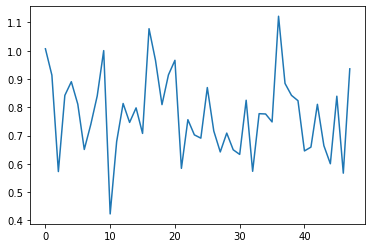

In [64]:
plt.plot(loss_list[::100])

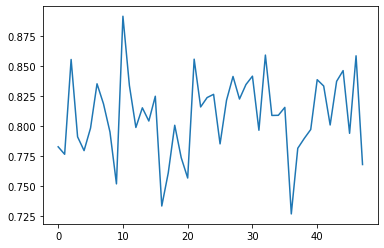

In [65]:
plt.plot(acc_list[::100])

In [66]:
test_loss_list = []
test_acc_list = []
test_pr_list = []

model.eval()
for test_inputs, test_labels in test_loader:
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
    test_output = model(test_inputs)
    test_loss = loss_function(test_output.squeeze(), test_labels.float())
    test_loss_list += [test_loss.clone().detach()]
    
    accuracy = (test_output > 0.5).long() == test_labels
    pr_auc = average_precision_score(test_labels, test_output.long())
    test_acc_list += [accuracy.detach().float().mean()]
    test_pr_list += [pr_auc]
    
print("Test loss: {:.3f}".format(np.mean(test_loss_list)))
print("Test accuracy: {:.3f}%".format(np.mean(test_acc_list)))

C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Ev.Romanenkova\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test loss: 0.634
Test accuracy: 0.841%


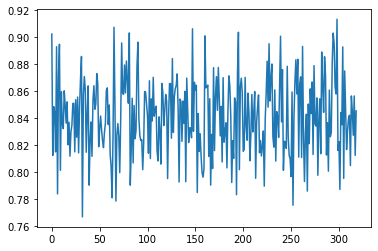

In [67]:
plt.plot(test_acc_list)

In [68]:
np.mean(test_pr_list)

0.15877827133130878

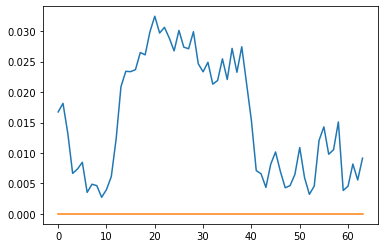

In [83]:
plt.plot(output[0].detach().numpy());
plt.plot(labels[0].detach().numpy());

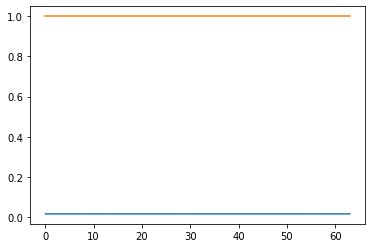

In [85]:
plt.plot(output[6].detach().numpy());
plt.plot(labels[6].detach().numpy());

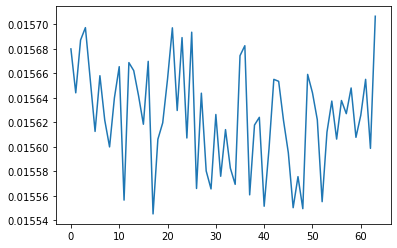

In [86]:
plt.plot(output[7].detach().numpy());
#plt.plot(labels[7].detach().numpy());

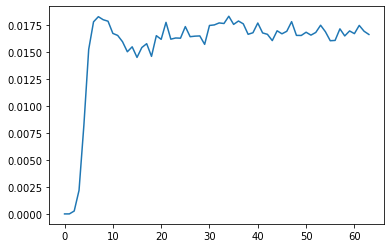

In [87]:
plt.plot(output[8].detach().numpy());
#plt.plot(labels[8].detach().numpy());